In [1]:
import re
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
sns.set()

api = wandb.Api()


def get_iid_accs(r):
    accs = []
    if 'output.log' in [f.name for f in r.files()]:
        r.file('output.log').download(replace=True)
        with open('output.log', 'r') as f:
            for line in f:
                if re.search('Task \d IID Test Accuracy: (.*)$\n', line):
                    iid = float(
                        re.match('Task \d IID Test Accuracy: (.*)$\n', line).groups()[0])
                    accs.append(iid)
    return accs

def load_sweeps(sweeps, parse_iid=False):
    dfs = []
    for s in sweeps:
        if Path(f'saved_dfs/{s}').exists():
            dfs.append(pd.read_pickle(Path(f'saved_dfs/{s}')))
        else:
            sweep = api.sweep(f"clip_cl/CL-Similarity/{s}")
            results = []
            for run in sweep.runs:
                summary = {k: v for k, v in run.summary._json_dict.items()
                        if not k.startswith('_')}
                config = {k: v for k, v in run.config.items()
                        if not k.startswith('_')}
                name = {'name': run.name}
                res = summary | config | name
                if parse_iid:
                    res['iid_accs'] = get_iid_accs(run)
                results.append(res)
            my_df = pd.DataFrame(results)
            my_df.to_pickle(Path(f'saved_dfs/{s}'))
            dfs.append(my_df)
    df = pd.concat(dfs)
    df.loc[df.replay_size_per_class == -1, 'replay_size_per_class'] = 'All samples'
    return df


df = load_sweeps(['uv2kvsoa'], parse_iid=True)
df_init = load_sweeps(['z85e3el7'], parse_iid=True)


In [2]:
mean_transfer = []
all_transfers = []
for i in range(df.shape[0]):
    df_row = df.iloc[i]
    df_init_row = df_init.loc[
        (df_init.dataset == df_row.dataset) &
        (df_init.n_classes_per_task == df_row.n_classes_per_task) &
        (df_init.model == df_row.model) &
        (df_init.seed == df_row.seed)
    ]
    cl_iid_accs = df_row.iid_accs
    init_iid_accs = df_init_row.iid_accs.values[0]

    if len(cl_iid_accs) != len(init_iid_accs):
        print(len(cl_iid_accs), len(init_iid_accs))
        mean_transfer.append(0)
        all_transfers.append(np.zeros(4))
    else:
        mean_transfer.append((df_row['mean_iid_acc'] - df_init_row['mean_iid_acc']).values[0])
        all_t = np.array(cl_iid_accs) - np.array(init_iid_accs)
        all_transfers.append(all_t[1:]/100)

#     try:
#         # if i == 373:
#         #     print(df.iloc[i].iid_accs)
#         #     print(df_init.iloc[i].iid_accs)
#         #     print(np.array(df.iloc[i].iid_accs) -
#         #           np.array(df_init.iloc[i].iid_accs))
#         print(df_row.iid_accs)
#         print(df_init_row.iid_accs.values[0])
#         all_t = np.array(
#             df_row.iid_accs) - np.array(df_init_row.iid_accs.values[0])
#     except:
#         t2 = df_init_row.iid_accs.values[0]
#         t2.append(df_row.iid_accs[-1])
#         all_t = np.array(df_row.iid_accs) - \
#             np.array(t2)
#     mean_transfer.append((df_row['mean_iid_acc'] -
#                               df_init_row['mean_iid_acc']))
#     all_transfers.append(all_t[1:]/100)
df['mean_transfer'] = np.array(mean_transfer)
df['all_transfers'] = all_transfers


4 5


In [14]:
# metrics = ['entropy_ratio', 'entropy_diff', 'max_prob_diff', 'max_prob_ratio', 'max_logit_diff', 'max_logit_ratio', 'kl_div', 'all_sims']
# for m in metrics:
#     df = df.rename(columns={m:f'metric_{m}'})
metrics = [c for c in df.columns if c.startswith('metric_')]

In [18]:
import itertools
def plot_perf(df, x, hue, figsize=(20, 10), savefig=None):
    fig, ax = plt.subplots(1, 4, figsize=figsize)
    for i, y in enumerate(['mean_iid_acc', 'cl_acc', 'mean_fgt', 'mean_transfer']):
        sns.barplot(data=df, x=x, y=y, hue=hue, ci='sd', ax=ax[i])
        ax[i].set_ylim(0, 1)
        ax[i].set_ylabel(['IID Acc', 'CL Acc', 'Forgetting', 'Transfer'][i])
    fig.tight_layout()
    if savefig:
        fig.savefig(savefig)


def create_corr_df(df, sim_metrics, agg_cols=['model', 'dataset', 'n_classes_per_task'], idx=False):
    if idx:
        agg_cols.append('task_idx')
    def dict_product(dicts):
        return list(dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))
    corr_results = []
    combinations = dict_product({x: list(df[x].unique()) for x in agg_cols})
    for c in combinations:
        tmp_df = df.loc[(df[list(c)] ==
                         pd.Series(c)).all(axis=1)]
        for i in ['all_cl_accs', 'all_fgts', 'all_transfers']:
            for j in sim_metrics:
                c[f'{i}_{j}'] = tmp_df[i].corr(tmp_df[j])
        corr_results.append(c)
    return pd.DataFrame(corr_results)


def create_corr_pivot_table(df, values='all_cl_accs_all_sims', index=['model', 'dataset'], columns=['n_classes_per_task'], savefig=None):
    df = df.pivot_table(values=values, index=index, columns=columns,
                        aggfunc=np.sum).rename_axis(columns=None)
    if savefig:
        t = df.style.format(precision=2)
        t.to_latex(buf=savefig, hrules=True)
    return df


In [15]:
runs_df = df
runs_df = runs_df.loc[(runs_df['cl_acc'].notna()) &
                      (runs_df['replay_size_per_class'] == 'All samples')]

blowup_cols = ['all_cl_accs', 'all_fgts', 'task_idx', 'all_transfers'] + metrics
runs_df['task_idx'] = [np.arange(4) + 1 for i in range(runs_df.shape[0])]
sim_df = runs_df.explode(blowup_cols, ignore_index=True)
for col in blowup_cols:
    sim_df[col] = np.float64(sim_df[col])


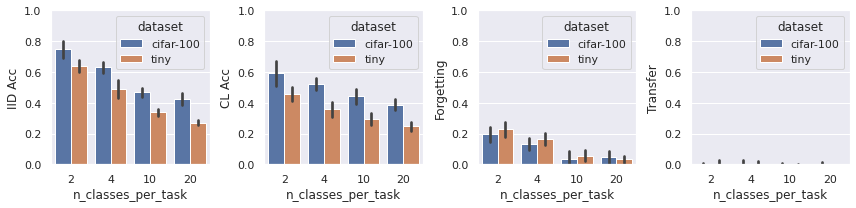

In [17]:
plot_perf(runs_df, hue='dataset', x='n_classes_per_task', figsize=(12, 3), savefig='../figures/perf.png') 

In [19]:
corr_df = create_corr_df(sim_df, sim_metrics=metrics)
# corr_df = corr_df[['model', 'dataset',
#                    'n_classes_per_task', 'all_cl_accs_all_sims']]
# create_corr_pivot_table(corr_df).style.format(precision=2).highlight_min(
#     axis=0, props='bfseries: ;').to_latex(
#         caption='test', hrules=True, buf='../figures/cl_acc.tex')

# # .style.format(precision=2).to_latex(
# #     caption='test', hrules=True, buf='cl_acc.tex')


# corr_df = create_corr_df(sim_df)
# corr_df = corr_df[['model', 'dataset',
#                    'n_classes_per_task', 'all_fgts_all_sims']]
# create_corr_pivot_table(corr_df, values='all_fgts_all_sims').style.format(precision=2).highlight_max(
#     axis=0, props=' bfseries: ;').to_latex(
#     caption='test', hrules=True, buf='../figures/fgt.tex')

# corr_df = create_corr_df(sim_df)
# corr_df = corr_df[['model', 'dataset',
#                    'n_classes_per_task', 'all_transfers_all_sims']]
# create_corr_pivot_table(corr_df, values='all_transfers_all_sims').style.format(precision=2).highlight_max(
#     axis=0, props='bfseries: ;').to_latex(
#     caption='test', hrules=True, buf='../figures/transfer.tex')




In [20]:
# ## Create complete tables
# corr_df = create_corr_df(sim_df, idx=True)
# corr_df = corr_df[['model', 'dataset',
#                    'n_classes_per_task', 'all_cl_accs_all_sims', 'task_idx']]
# create_corr_pivot_table(corr_df, index=['task_idx', 'model', 'dataset']).style.format(precision=2).to_latex(caption='Com', hrules=True, buf='../figures/complete_cl_acc.tex')


# corr_df = create_corr_df(sim_df, idx=True)
# corr_df = corr_df[['model', 'dataset',
#                    'n_classes_per_task', 'all_fgts_all_sims', 'task_idx']]
# create_corr_pivot_table(corr_df, values='all_fgts_all_sims', index=['task_idx', 'model', 'dataset']).style.format(precision=2).to_latex(caption='Com', hrules=True, buf='../figures/complete_fgt.tex')

# corr_df = create_corr_df(sim_df, idx=True)
# corr_df = corr_df[['model', 'dataset',
#                    'n_classes_per_task', 'all_transfers_all_sims', 'task_idx']]
# create_corr_pivot_table(corr_df, values='all_transfers_all_sims', index=['task_idx', 'model', 'dataset']).style.format(
#     precision=2).to_latex(caption='Com', hrules=True, buf='../figures/complete_transfer.tex')


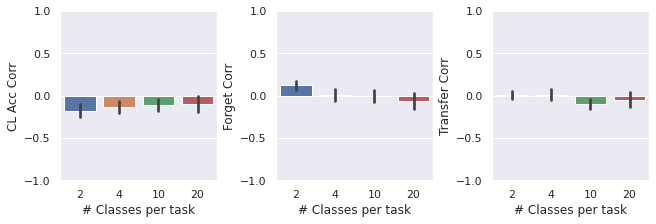

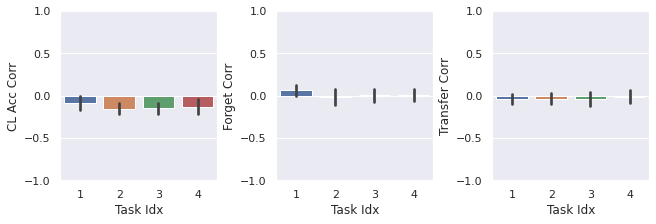

In [32]:
def corr_bar_plot(df, x='n_classes_per_task', xlabel=None, final_layer=False, savefig=None):
    if final_layer:
        ys = ['all_cl_accs_final_sims', 'all_fgts_final_sims', 'all_transfers_final_sims']
    else:
        ys = ['all_cl_accs_all_sims', 'all_fgts_all_sims', 'all_transfers_all_sims']
    fig, ax = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)
    sns.barplot(data=df, x=x, y=ys[0], ax=ax[0])
    sns.barplot(data=df, x=x, y=ys[1], ax=ax[1])
    sns.barplot(data=df, x=x, y=ys[2], ax=ax[2])
    ax[0].set_ylabel('CL Acc Corr')
    ax[1].set_ylabel('Forget Corr')
    ax[2].set_ylabel('Transfer Corr')
    for a in ax:
        a.set_ylim(-1, 1)
        if xlabel:
            a.set_xlabel(xlabel)
    if savefig:
        fig.savefig(savefig)

corr_df = create_corr_df(sim_df)
corr_df_idx = create_corr_df(sim_df, idx=True)

corr_bar_plot(corr_df, xlabel='# Classes per task', savefig='../figures/corr_classes_per_task.png')
corr_bar_plot(corr_df_idx, x='task_idx', xlabel='Task Idx',
              savefig='../figures/corr_idx.png')


In [18]:
def plot_sim(df, x, y, figsize=(12, 15), savefig=None, model=None, n_classes_per_task=[2, 4, 10, 20], ylim=None, xlim=None):
    fig = plt.figure(constrained_layout=True, figsize=(
        len(n_classes_per_task) * 5, 20))
    subfigs = fig.subfigures(4, 1, wspace=0.07)

    if model:
        df = df.loc[df['model'] == model]
    def make_plot(df, ax, hue):
        hue_order = sorted(df[hue].unique())
        sns.scatterplot(data=df, ax=ax, x=x,
                            y=y, hue=hue, hue_order=hue_order)

    for i, task_idx in enumerate([1, 2, 3, 4]):
        # subfigs[i].suptitle(d[1], fontweight="bold")
        axes = subfigs[i].subplots(1, len(n_classes_per_task))
        subfigs[i].supylabel(f'After task: {task_idx + 1}')
        for j, n_class_per_task in enumerate(n_classes_per_task):
            if len(n_classes_per_task) == 1:
                ax = axes
            else:
                ax = axes[j]
            ax_df = df.loc[
                (df['n_classes_per_task'] == n_class_per_task) &
                (df['task_idx'] == task_idx)]
            hue = 'dataset'
            make_plot(ax_df, ax, hue)
            if ylim:
                ax.set_ylim(*ylim)
            if xlim:
                ax.set_xlim(*xlim)
            ax.set_xlabel(None)
            ax.set_ylabel(None)
            ax.set_title(
                f'N Classes per task: {n_class_per_task}' if i == 0 else None)
            if not model:
                ax.legend(loc='lower right')
    if savefig:
        fig.savefig(savefig)


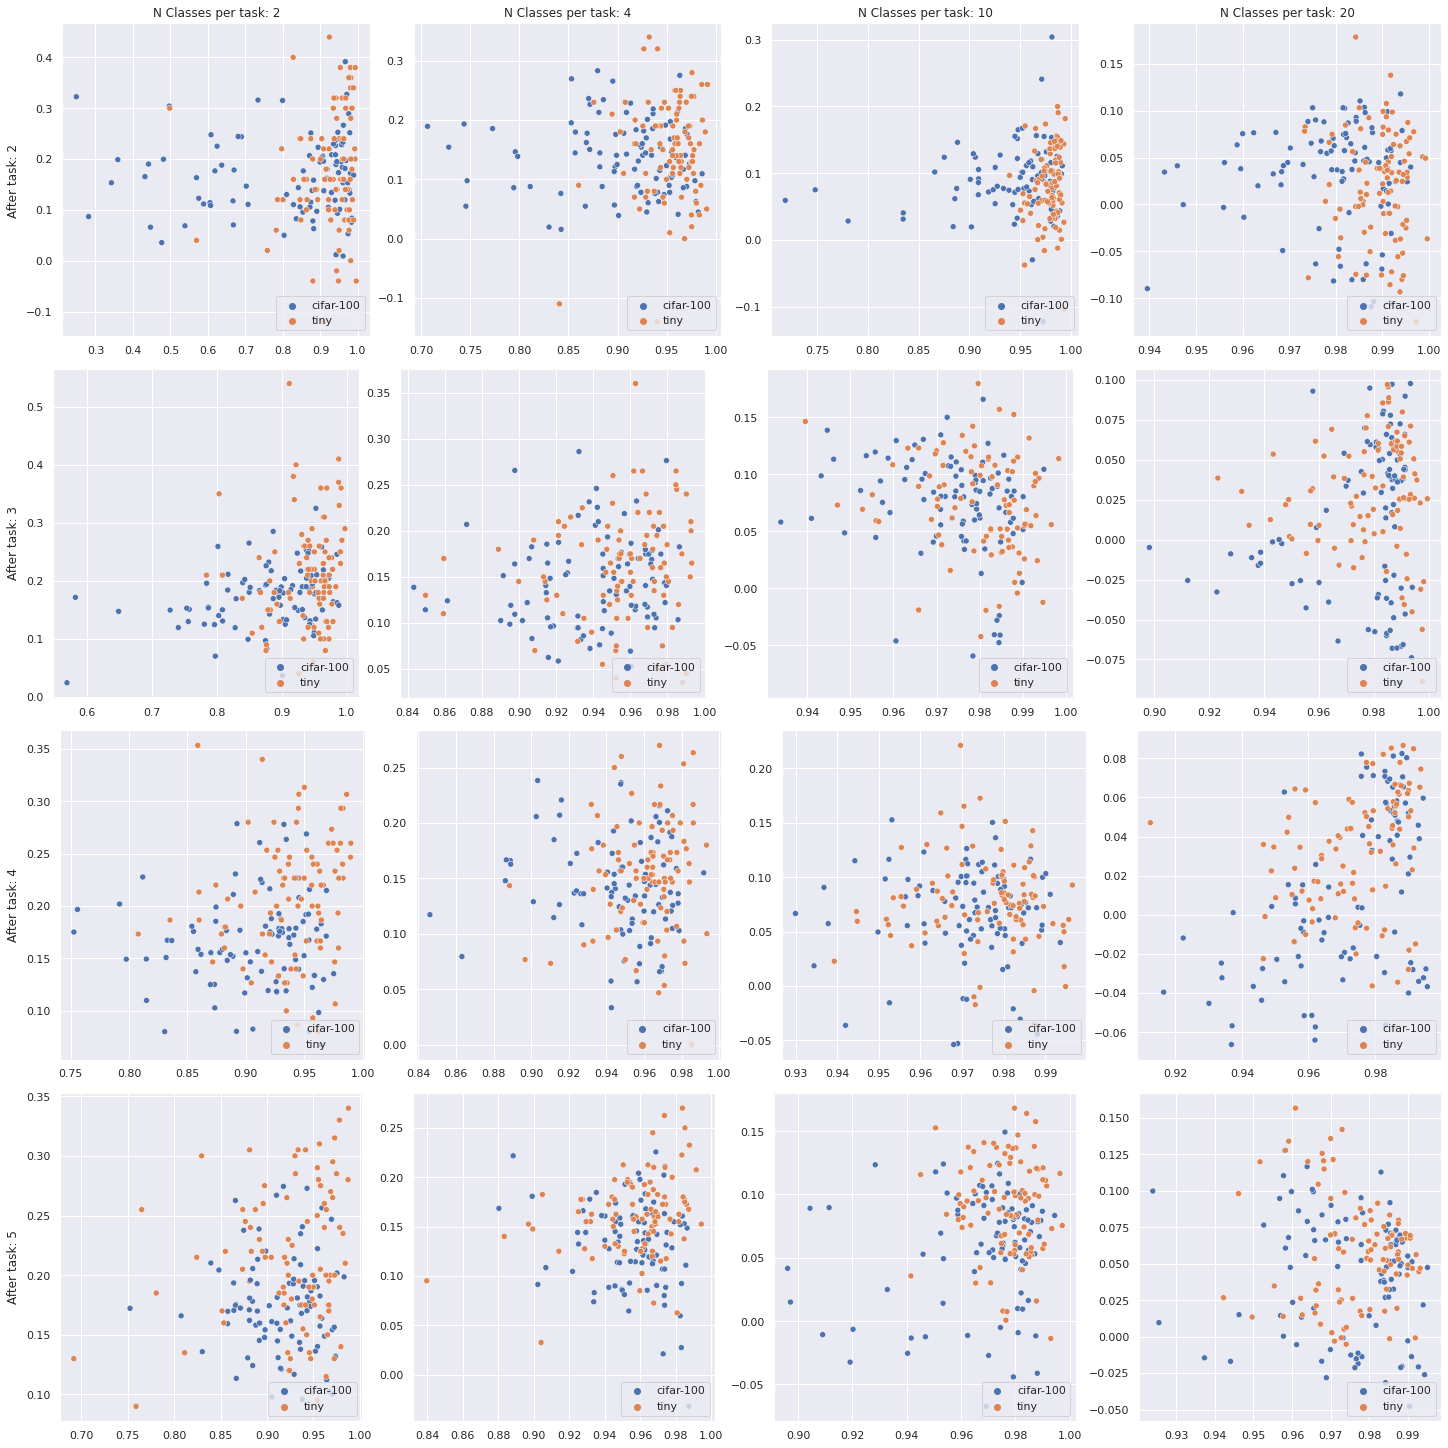

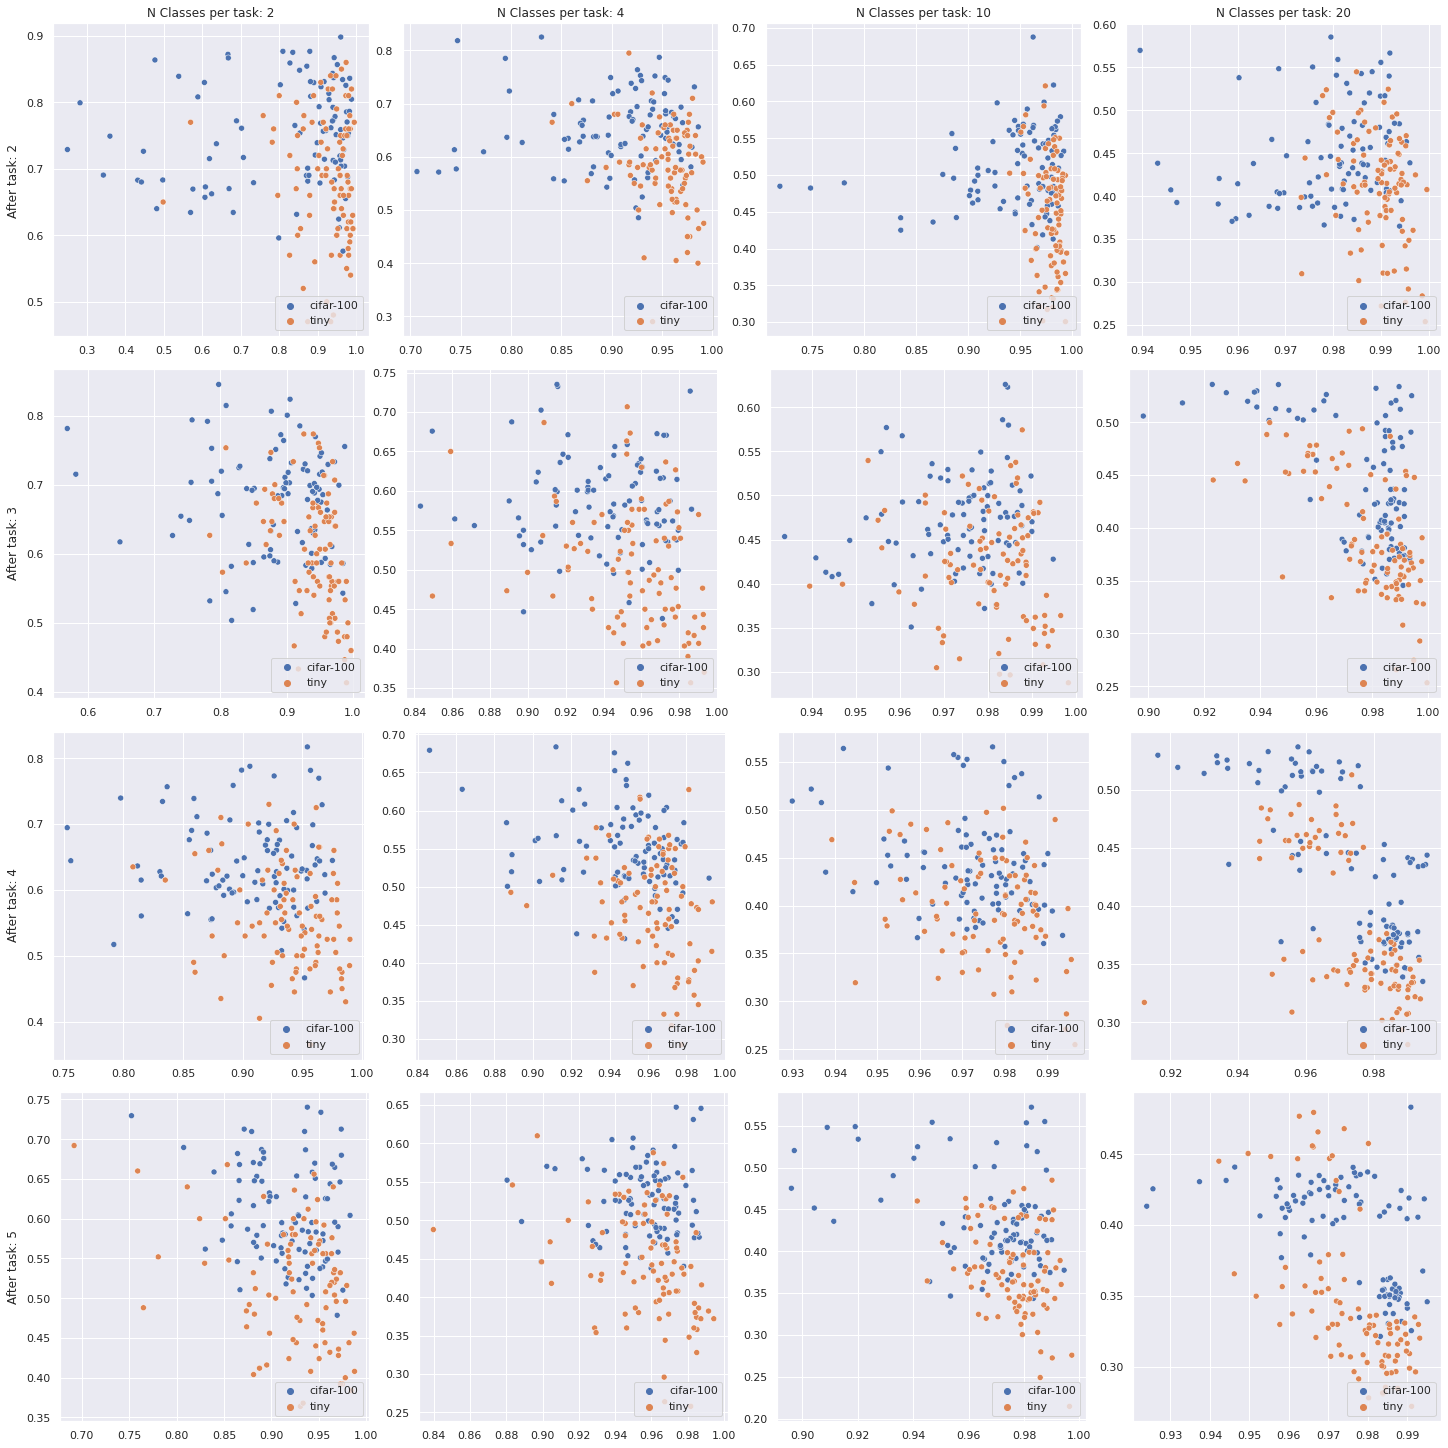

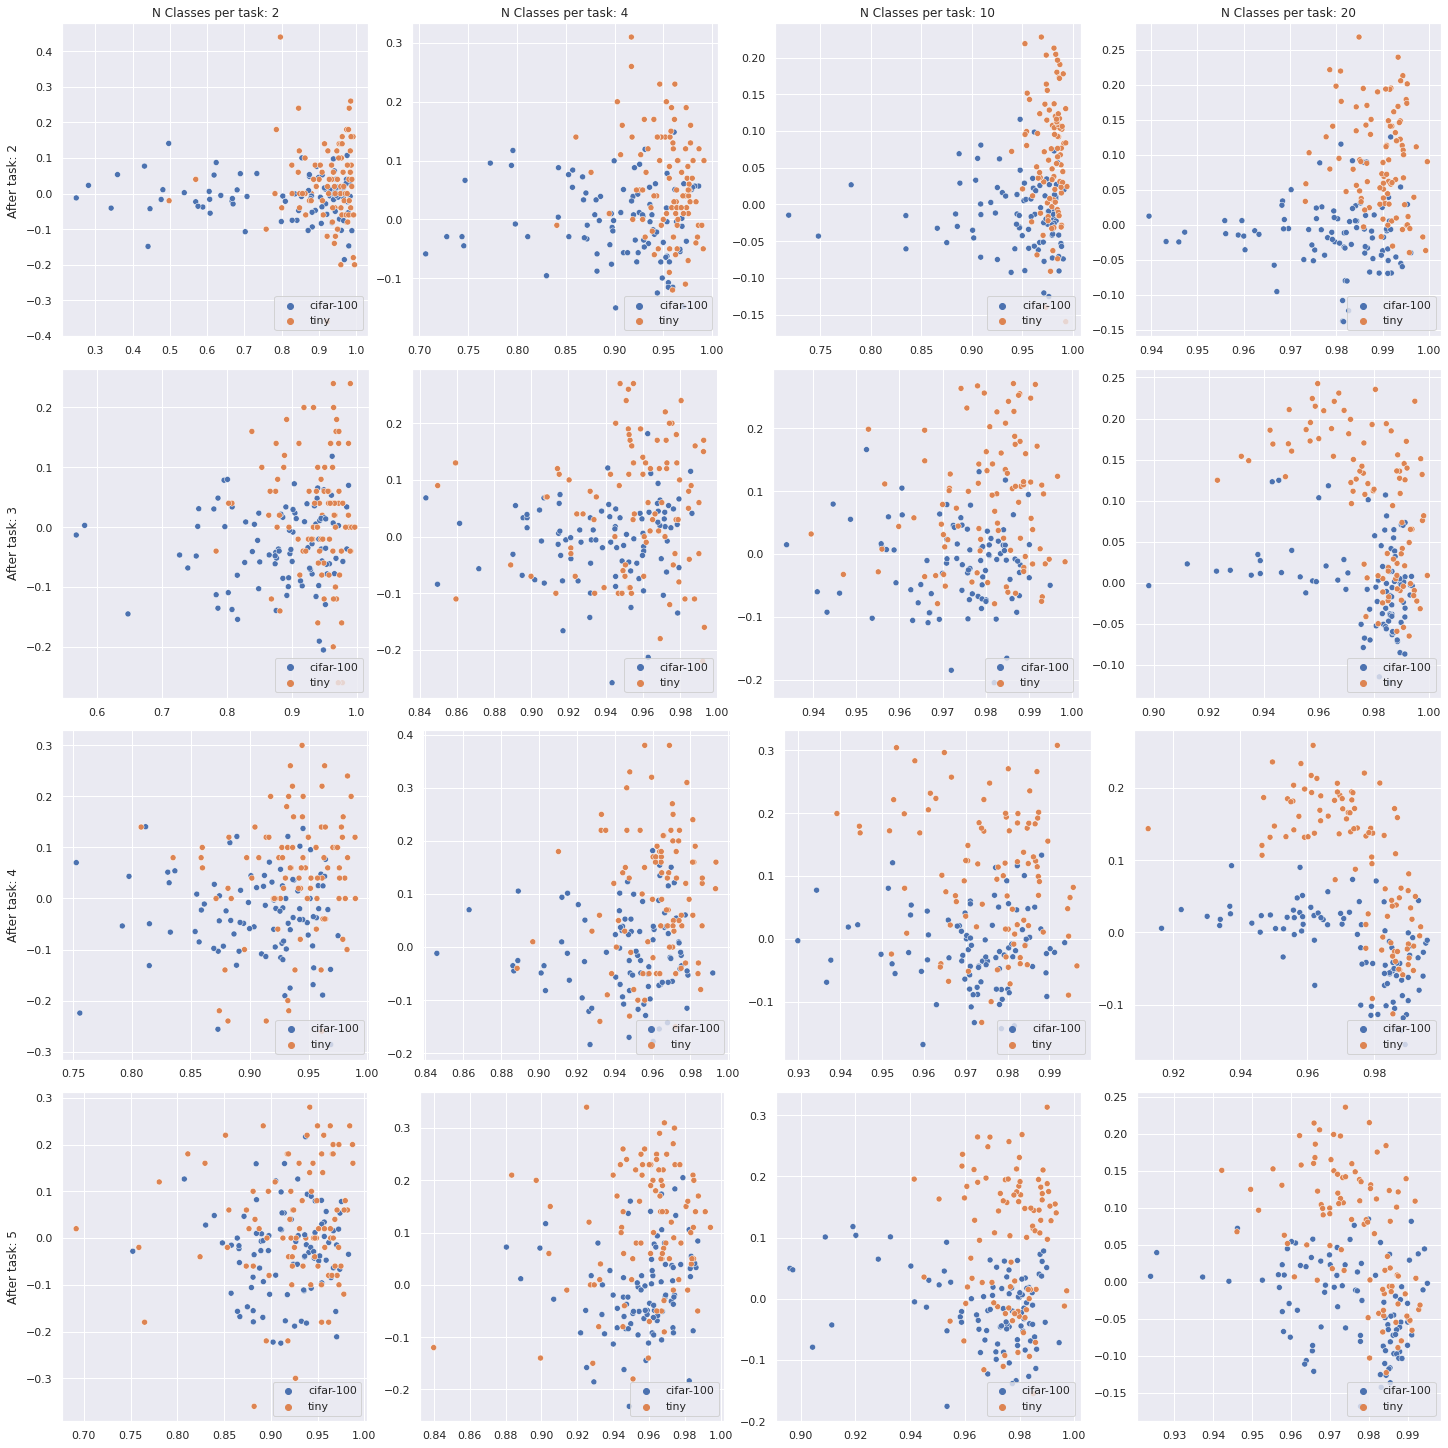

In [25]:
plot_sim(df=sim_df, x='all_sims', y='all_fgts',
         savefig='../figures/all_sim_fgt.png')
plot_sim(df=sim_df, x='all_sims', y='all_cl_accs', savefig='../figures/all_sim_acc.png')
plot_sim(df=sim_df, x='all_sims', y='all_transfers',
         savefig='../figures/all_sim_transfer.png')


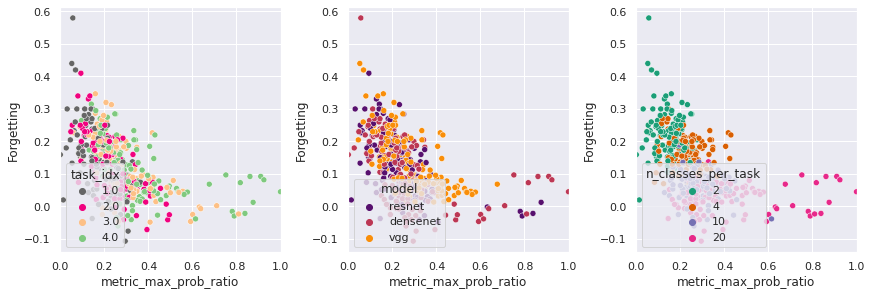

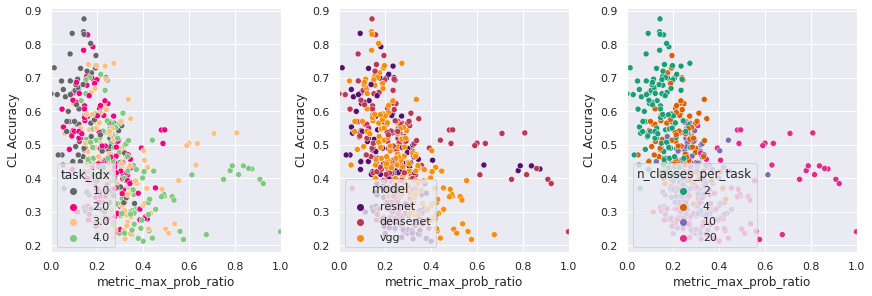

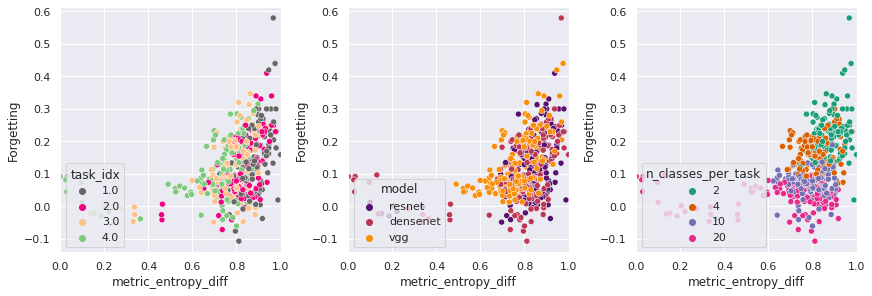

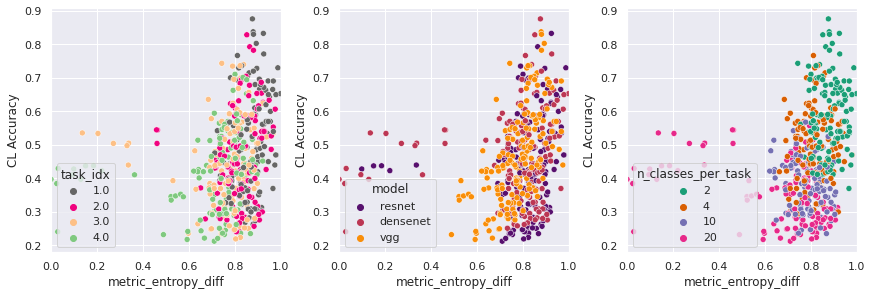

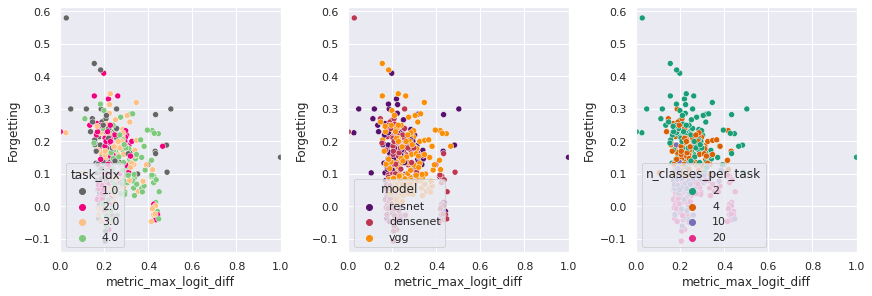

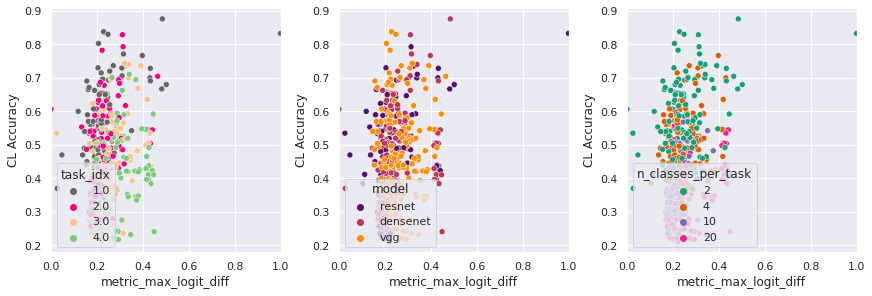

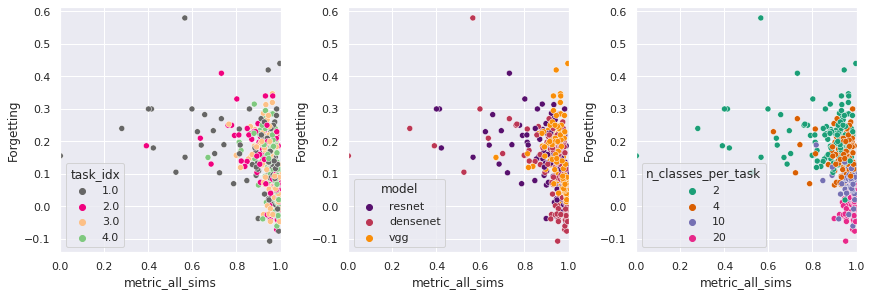

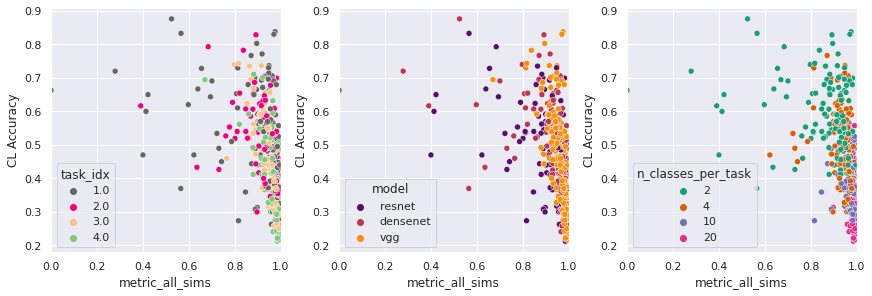

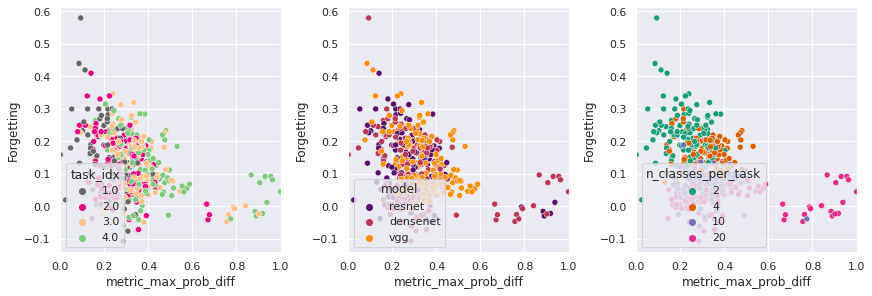

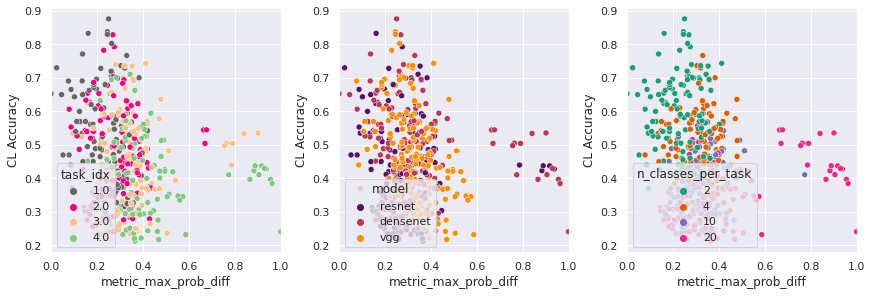

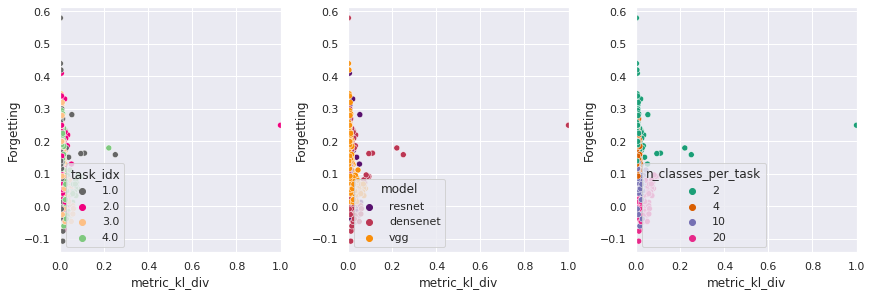

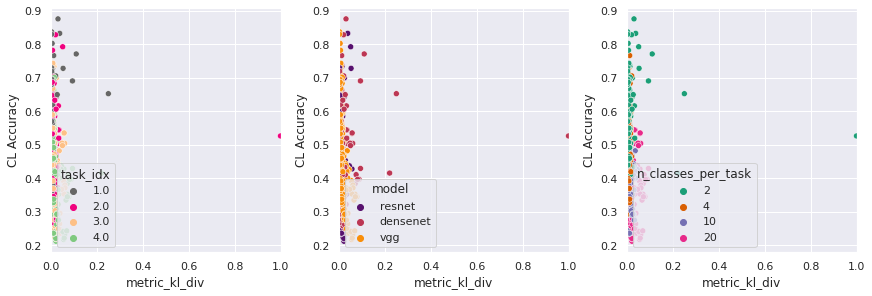

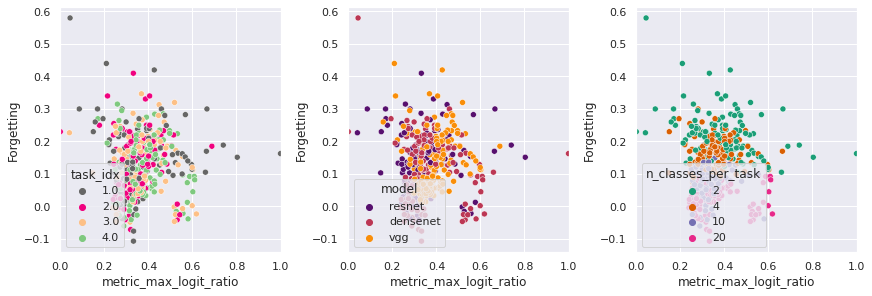

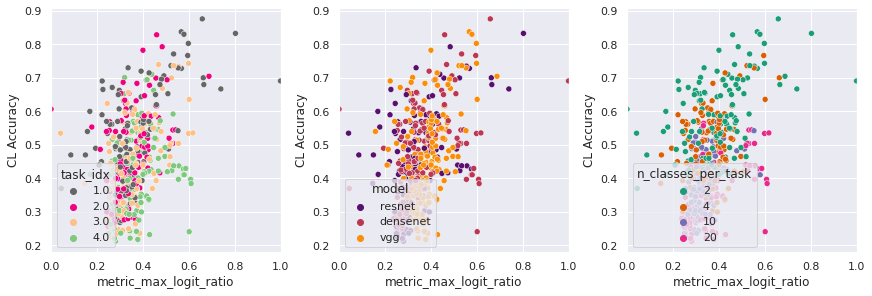

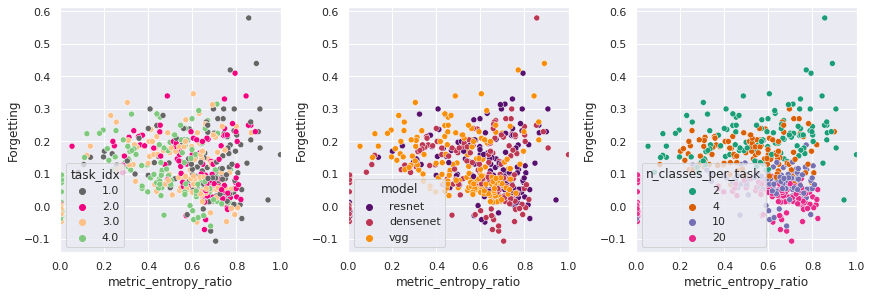

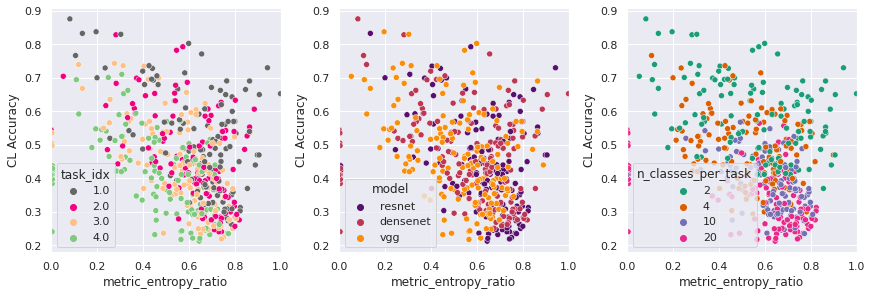

In [26]:
def plot_sims_v2(df, x, y, savefig=None, **plot_args):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    palettes = ['Accent_r', 'inferno', 'Dark2']
    for i, hue in enumerate(['task_idx', 'model', 'n_classes_per_task']):
        plot = sns.scatterplot(
            data=df, ax=ax[i], x=x, y=y, hue=hue, palette=palettes[i])
        ax[i].legend(loc='lower left', title=hue)
        ax[i].set_xlim(0, 1)
        if plot_args:
            plot.set(**plot_args)
    if savefig:
        fig.savefig(savefig)

for m in metrics:
    sim_df[m] = (sim_df[m] - sim_df[m].min()) / (sim_df[m].max() - sim_df[m].min())    
    plot_sims_v2(df=sim_df, x=m, y='all_fgts', **dict(xlabel=m, ylabel='Forgetting'), savefig='../figures/fgt_scatter.png')
    plot_sims_v2(df=sim_df, x=m, y='all_cl_accs', **dict(xlabel=m, ylabel='CL Accuracy'), savefig='../figures/acc_scatter.png')
    # plot_sims_v2(df=sim_df, x=m, y='all_transfers', **dict(xlabel=m, ylabel='Transfer'), savefig='../figures/transfer_scatter.png')
            